In [1]:
import numpy as np
import numpy.linalg as la
from matplotlib import pyplot as plt
import pandas as pd
import cmath

# Problem 2

In [2]:
h_static = np.load('h_static.npy')
t_static = np.load('t_static.npy')

## Problem 2-1) i.

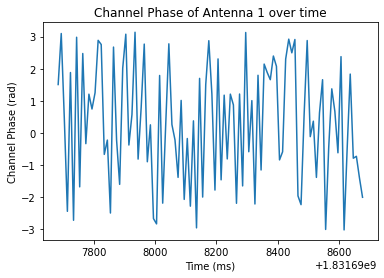

In [128]:
phase = np.angle(h_static[:,0])
phase_2 = np.angle(h_static[:,1])

plt.title("Channel Phase of Antenna 1 over time")
plt.xlabel("Time (ms)")
plt.ylabel("Channel Phase (rad)")
plt.plot(t_static, phase)

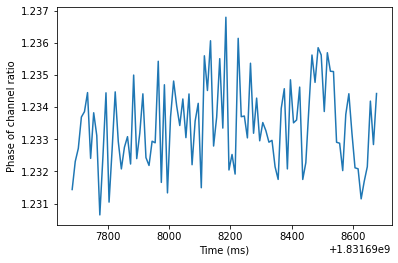

In [139]:
# ratio2 = phase / phase_2
ratio = np.angle(h_static[:,0]/ h_static[:,1])
plt.title("Phase difference between two antenna")
plt.ylabel('Phase of channel ratio')
plt.xlabel('Time (ms)')
plt.plot(t_static, ratio)
# plt.plot(t_static, ratio2)

In [150]:
# https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

# r = reject_outliers(ratio)
np.rad2deg(np.arccos(np.average(ratio) / np.pi)) # calculate AoA



66.88238643991556

### iv.
The phase almost remains constant for the entire duration. The reason for this is because although $h_1$ and $h_2$ change a lot relative to the base transmitter, but they do not change that much relative to each other. This is because they are on the same device which is receiving. We can use this to our advantage by performing calculations after cancelling out the CFO problem by comparing the ratio of two transmitters' channel value instead. 

## Problem 2-2)

In [6]:
h1_move = np.load('h1_move.npy')
h2_move = np.load('h2_move.npy')
t1_move = np.load('t1_move.npy')
t2_move = np.load('t2_move.npy')

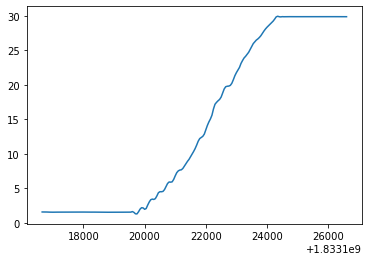

In [7]:
phase = np.angle(h1_move[:,0] / h1_move[:,1]) # Same as np.angle(h1_move[:,0]) - np.angle(h2_move[:,1])
# phase = np.angle(h1_move[:,0]) / np.angle(h1_move[:,1])
plt.plot(t1_move, np.unwrap(phase))
# plt.plot(t1_move, phase)

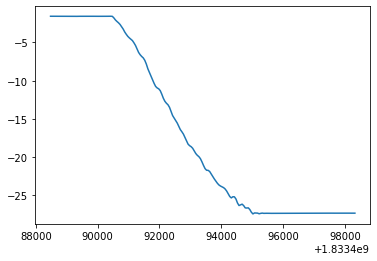

In [8]:
phase_2 = np.angle(h2_move[:,0] / h2_move[:,1])
plt.plot(t2_move, np.unwrap(phase_2))
# plt.plot(t2_move, phase_2)

<ipython-input-15-28c09df78245>:7: RuntimeWarning: invalid value encountered in arccos
  plt.plot(t1_move, np.rad2deg(np.arccos(np.unwrap(ang1 - ang2) / np.pi)))


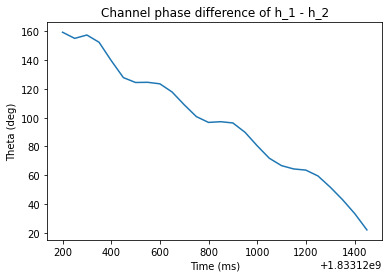

In [15]:
# This is for h1_move
ang1 = np.angle(h1_move[:,0])
ang2 = np.angle(h1_move[:,1])
plt.title("Channel phase difference of h_1 - h_2")
plt.xlabel("Time (ms)")
plt.ylabel("Theta (deg)")
plt.plot(t1_move, np.rad2deg(np.arccos(np.unwrap(ang1 - ang2) / np.pi)))

As we can see with the two graphs of `phase_1` and `phase_2`, the first phase increases positively, which means that $\angle h_1 > \angle h_2$ and if we take $h_1$ to be the channel of the right antenna, **then we have `h1_move` as going from left to right, and `h2_move` as going from right to left.**

## Problem 2-3)

p_ is given by

$p(h, \phi, \theta') = he^{-j2\pi \frac{Rcos(\phi - \theta')}{\lambda}}$

And $P$ is given by

$P(\theta') = \Sigma_{k=0}^{n-1}p(h_k, \phi_k, \theta')$

In [82]:
# Constants
# phi_dot = 2*np.pi / 12.25 # 12.25 seconds per rotation
def phi_dot(ms):
    return 2*np.pi / 12.25 * (ms / 1000)

R = 0.208 # radius in meters of antenna array (roomba in this case)
c = 3E8 # Speed of light
freq = 5.5E9 # 5.5 Ghz
wavelength = c / freq # lambda

# Load data
circular_h = np.load('circular_h.npy')
circular_t = np.load('circular_t.npy')
solution = np.load('MultipathProfile.npy')

def p_(h: complex, phi, theta, R):
    """Inside summation for P(\theta')
    """
    frac = (R * np.cos(phi - theta)) / wavelength
    exp = -2 * np.pi * 1j * frac
    return h * np.exp(exp)

In [103]:
# Testing idea
# thetas = np.radians(np.linspace(-180, 180, 361))
# phis = phi_dot(circular_t[:,0])
# ratio = circular_h[:,1] / circular_h[:,0]
# P = np.zeros(thetas.shape)
# for i in range(thetas.shape[0]):
#     arr = np.zeros(phis.shape[0], dtype=complex)
#     for k in range(arr.shape[0]):
#         # print(p_(ratio[k], phis[k], thetas[i], R))
#         # arr[k] = p_(ratio[k], phis[k], thetas[i], R)
#         num = R * np.cos(phis[k] - thetas[i])
#         denom = wavelength
#         arr[k] = ratio[k] * np.exp(-1j*2*np.pi*(num/denom))
#         # print(ratio.shape, phis.shape)
#     P[i] = abs(np.sum(arr))**2

# plt.plot(thetas, P)

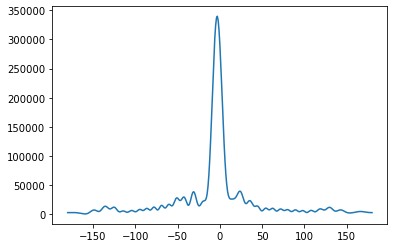

In [123]:
def P(hs, R, theta):
    """Summation of dot product to theta
    """
    phis = phi_dot(circular_t[:,0])
    arr = p_(hs, phis, theta, R)
    return abs(np.sum(arr))**2

ratio = circular_h[:,1] / circular_h[:,0]
thetas = np.radians(np.linspace(-180, 180, 361))
P_thetas = np.array([P(ratio, R, theta) for theta in thetas])
plt.plot(np.rad2deg(thetas), P_thetas)

(1, 121)

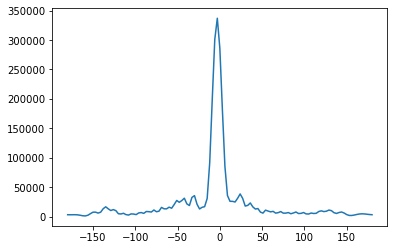

In [109]:
plt.plot(np.linspace(-180, 180, 121), solution[0])

In [122]:
# Compare to solution
output = P_thetas[::3].copy()
rel_err = la.norm(output - solution[0]) / la.norm(solution[0]) # uses 2 norm
rel_err # in percent

0.03211333821616907